In [1]:
import numpy as np
from scipy.signal import convolve2d 
from os import path, getcwd, system, getenv
from astropy.io import fits
from time import perf_counter
import urllib.request
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import matplotlib.gridspec as gridspec

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import sys,inspect
currentdir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = path.dirname(currentdir)
sys.path.append(parentdir)
# from deconv import cube_deconv
# from ppxf_wrap import ppxf_wrap

# import warnings

# if True:
#     print('Set warnings.filterwarnings as "ignore"')
#     print('Warning Message will not be printed')
#     warnings.filterwarnings("ignore")

from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import constants
import pandas as pd

# import plotly.express as px
from astroquery.mast import Observations


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.nddata.utils import Cutout2D

from astropy.wcs import WCS
import astropy

from urllib.error import HTTPError
from astroquery.skyview import SkyView

computer = 1

In [2]:
#Skyview Query by Object name or Coordinate, reads in the from Object table. 
#Image Download block

size = 1600

width_val = u.Quantity(size, unit = 'arcsec')
height_val =  u.Quantity(size, unit = 'arcsec')


# objnames = ['NGC 7714','NGC 7673','NGC 7662','NGC 7496','NGC 7469','NGC 7354',
# 'NGC 6826','NGC 7094','NGC 7090','NGC 7078','NGC 7027',
# 'NGC 7023','NGC 7009','NGC 6992','NGC 6905','NGC 6891']

t3 = []
if computer == 2:
    t = pd.read_table("C:/Users/maxri/OneDrive/Desktop/Classes 4-1/Research/fuse/objs2.tbl",header=None)
if computer == 1:
    t = pd.read_table("C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/objs2.tbl",header=None)
    
for i in t.values:
    t3.append(i[0])
    
objnames = t3


obstables2 = []; coords = [];

#pixels initially 300 x 300
#Initial Skyview Query by name

surveys = ['DSS', 'DSS1 Blue', 'DSS1 Red', 'DSS2 Red', 'DSS2 Blue', 'DSS2 IR'] #use surveyindex = 3 Dss2red

surveyindex = 3


for i in objnames:
        paths = [];
        try:
            paths = SkyView.get_images(position = i, 
                       survey=surveys[surveyindex],width = width_val,height = height_val,pixels = [1000,1000])
            hdr = paths[0][0].header
            a = hdr['HISTORY'][33].split()
            cd= [float(a[2]),float(a[3])]
            print(i,surveys[surveyindex])
            c = SkyCoord(cd[0],cd[1], unit=u.deg)
            coords.append(c)
    
        except HTTPError:
            print("No Result for ", i, surveys[surveyindex])
        obstables2.append(paths)
        
        
        
result = pd.DataFrame(obstables2)

obstables2, result, coords

NGC 7714 DSS2 Red
NGC 7673 DSS2 Red
NGC 7662 DSS2 Red
NGC 7496 DSS2 Red
NGC 7469 DSS2 Red
NGC 7354 DSS2 Red
NGC 6572 DSS2 Red
NGC 7094 DSS2 Red
NGC 7090 DSS2 Red
NGC 7078 DSS2 Red
NGC 7027 DSS2 Red
NGC 7023 DSS2 Red
NGC 7009 DSS2 Red
NGC 6992 DSS2 Red
NGC 6905 DSS2 Red
NGC 6891 DSS2 Red


([[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000273012D1750>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000273019FA050>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000273020EFBB0>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027302050190>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027300C8DD20>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027301FA7880>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027301865540>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000273017BE7D0>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027302016440>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027302631F30>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027302573AC0>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000027302633A30>]],
  [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002730127A7D0>]],
  [[<astropy.io.fits.hdu.

In [3]:
#Save Code Block, to same convention as before

result;
coords
skydown ="./images_redTEST/"
for i in range(len(result)):
    a = surveys[surveyindex].split()
    b = objnames[i].split()
    if i < 9:
        fname = "000{}_{}_{}_{}_{}".format(i+1,coords[i].ra.deg,coords[i].dec.deg,a[0]+a[1],b[0]+b[1])
    else:
        fname = "00{}_{}_{}_{}_{}".format(i+1,coords[i].ra.deg,coords[i].dec.deg,a[0]+a[1],b[0]+b[1])
    #print(fname)
    result[0][i][0].writeto(skydown+fname+".fits", output_verify='exception', overwrite=True, checksum=False)
    
    

In [4]:
#MAin FUSE DOWNLOAD BLOCK
def set_rcparams_prop(amp=1, fs=22, tickamp=None):
    fs=18
    if tickamp==None:
        tickamp=amp
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*tickamp
    tmns=tmjs/3.5*2
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

obs_tables=[]
for objname in objnames:
    print(objname)
    obs_tables.append(Observations.query_criteria(obs_collection='FUSE',objectname=objname, radius=".5 deg"))

#Main Fuse Download
fnames=[]


#download files
if computer == 1:
    down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/'
if computer == 2:
    down_dir = 'C:/Users/maxri/OneDrive/Desktop/Classes 4-1/Research/fuse/temp'

for i in range(len(obs_tables)):
# for i in [6]:
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
#     rr=[x.find('00000all3ttag') for x in urls]
#     dpl=pl[np.array(rr)>0]
#     print(urls)
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(obs_tables[i]['target_name'])
#     print(manifest)
#     needs documentation
    
#     exptimes=obs_tables[4]['t_exptime']
# #     print(exptimes)
# #     cond=exptimes>5000
#     # print(obs_tables[4][cond])
#     fexptimes=obs_tables[4][cond]['t_exptime']
    

NGC 7714
NGC 7673
NGC 7662
NGC 7496
NGC 7469
NGC 7354
NGC 6572
NGC 7094
NGC 7090
NGC 7078
NGC 7027
NGC 7023
NGC 7009
NGC 6992
NGC 6905
NGC 6891
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040021attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040021bttagfraw.fit.gz
                

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010021attagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/b0690301/b06903010041bsic4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010021attagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/p1074101/p10741010041bsic4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010021attagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/p1018703/p101870301300all4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0900102000\c090010200000all4ttagfcal.fit.gz with expected size 394273. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1018703000\p101870300000all4ttagfcal.fit.gz with expected size 617267. [astroquery.query]
target_name
-----------
    NGC7469
    NGC7469
    NGC7469
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0900101000\c090010100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0900102000\c090010200000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p101870300

                                 dataURI                                  
--------------------------------------------------------------------------
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701001fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701002fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701003fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701004fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701005fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701006fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701008fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701010fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701011fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/p1043701/p1043701012fesafraw.fit.gz
                                                                       ...
mast:FUSE/url/missions/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1043701000\p104370100000all4ttagfcal.fit.gz with expected size 617883. [astroquery.query]
target_name
-----------
    NGC7094
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1043701000\p104370100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101001fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101002fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101003fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101004fesbfraw.f

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101006fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101007fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101008fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101009fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101010fesafraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/p1330201/p13302010082bsic4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1330201000\p133020100000all4ttagfcal.fit.gz with expected size 611576. [astroquery.query]
target_name 
------------
NGC7078-K648
   PK65-27D1
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\d1570101000\d157010100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1330201000\p133020100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/b0390304/b0390304001fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0390304/b03903040011ahistfraw.fit.

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101006fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101007fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101008fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101009fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101010fesafraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/d1270701/d12707010052alif4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\i8011002000\i801100200000all4ttagfcal.fit.gz with expected size 613996. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\s5053101000\s505310100000all4ttagfcal.fit.gz with expected size 580476. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\s5053102000\s505310200000all4ttagfcal.fit.gz with expected size 607210. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\s5053102000\s505350100000all4ttagfcal.fit.gz with expected size 598944. [astroquery.query]
 target_name 
-------------
     HD200516
 NGC7009-POS1
 NGC7009-POS1
 NGC7009-POS2
 NGC7009-POS2
HD200516-BKGD
HD200516-BKGD
     HD200516
     HD200516
     HD200516
                                                     Local Path                     

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1140401000\p114040100000all4ttagfcal.fit.gz with expected size 616682. [astroquery.query]
target_name 
------------
KPD2055+3111
KPD2055+3111
  NGC6992-P1
  NGC6992-P2
   CYGLP-NE1
   CYGLP-NE1
   CYGLP-NE2
   CYGLP-NE3
   CYGLP-NE0
   CYGLP-NE4
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1140401000\p114040100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/a1490202/a1490202001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a1490202/a1490202002fesafraw.fit.gz
      mast:FUS

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\e5682201000\e568220100000all4ttagfcal.fit.gz with expected size 609462. [astroquery.query]
target_name 
------------
NGC6905-STAR
  WD2022+198
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\a1490202000\a149020200000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\e5682201000\e568220100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301002fesafraw.fit.

In [5]:
if computer == 1:
    down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/'
if computer == 2:
    down_dir = 'C:/Users/maxri/OneDrive/Desktop/Classes 4-1/Research/fuse/temp/'
    
# for i in range(len(obs_tables)):
# Pointings download/Creating organised Data Frames
df=pd.DataFrame()

# for i in range(1):
for i in range(len(obs_tables)):
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)
        
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)

# hdr        
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(manifest)

LWRS
LWRS
LWRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
MDRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS
LWRS
LWRS
MDRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS
RFPT
RFPT
RFPT


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\3013060444.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


In [6]:
#Max & Mean exposure calc
tcut=5000
tcut=2000
ndf=df[df['exptime']>tcut]

df2=pd.DataFrame()


for i in range(len(objnames)):
    print(objnames[i])
    adf=ndf[ndf['objname']==objnames[i]]
    adf.index=np.arange(len(adf))
    sri=pd.Series({
        'objname':objnames[i],
        'ra':adf.loc[0,'ra'],
        'dec':adf.loc[0,'dec'],
        'npt':len(adf),
        'maxexp':np.max(adf.loc[:,'exptime'].values),
        'meanexp':np.mean(adf.loc[:,'exptime'].values),
    })
    df2=df2.append(sri, ignore_index=True)
df2


# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check



NGC 7714
NGC 7673
NGC 7662
NGC 7496
NGC 7469
NGC 7354
NGC 6572
NGC 7094
NGC 7090
NGC 7078
NGC 7027
NGC 7023
NGC 7009
NGC 6992
NGC 6905
NGC 6891


C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\2658989492.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\2658989492.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\2658989492.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\2658989492.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Tem

,objname,ra,dec,npt,maxexp,meanexp
0,NGC 7714,354.058750,2.155167,8,51926.0,15674.250000
1,NGC 7673,351.923292,23.591861,1,9979.0,9979.000000
2,NGC 7662,351.475000,42.535008,1,10153.0,10153.000000
3,NGC 7496,347.446958,-43.427778,1,13232.0,13232.000000
4,NGC 7469,345.815083,8.873778,3,37630.0,14860.000000
5,NGC 7354,340.082917,61.285833,3,18812.0,11620.333333
6,NGC 6572,273.026250,6.853333,1,6883.0,6883.000000
7,NGC 7094,324.220750,12.788639,1,22754.0,22754.000000
8,NGC 7090,324.104167,-54.568056,1,21459.0,21459.000000
9,NGC 7078,322.497208,12.173947,2,27760.0,18473.500000


In [7]:
#Setup functions for plots, roudnings and rotating
def fstr(x):
    return x

def ff6(x):
    return '%.6f' % x


def ff4(x):
    return '%.4f' % x

def ff1(x):
    return '%.1f' % x

def ff2(x):
    return '%.2f' % x

def fint(x):
    return '%i' % x

def detection_check(x):
    if x>3:
        return 'Y'
    else:
        return 'N'

    
def rec_rotate(cx, cy, wx, wy, ang_deg): #angle: clocowise rot from 12h
    ang_rad=np.radians(ang_deg)
    wd=(wx**2+wy**2)**0.5
    ang_diagonal=np.arctan(wy/wx)
    ang_new=ang_diagonal+ang_rad
    rx=cx-wd/2*np.cos(ang_new)
    ry=cy-wd/2*np.sin(ang_new)
    return rx, ry
    
df2['randec']=df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['totalexp']=df2['meanexp']*df2['npt']

# coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.hourangle, u.deg))
coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.deg, u.deg))
df2['l']=coords.galactic.l.degree
df2['b']=coords.galactic.b.degree
# df2['rvel']=[269,850,308,500,133,465,241,-39,841,259,1127,757,976,470,610,528] #Radial Velocities
df2['rvel']=[2790,3400,-12.2,1647.9,4925,-42.5, -6.2,-101.1,850.0,-106.5,8.9,200,-46.6,200,-4.3,42.1] #Test Radial Velocities
#df2['rvel']=[269]

df2['lnb']=df2['l'].apply(ff4)+', '+df2['b'].apply(ff4)

df2['owave']=1031.9*(1+df2['rvel']/299790)

# fmts=[fstr, ff4, ff4, fint, fint, fint]
# fmts=[fstr, ff4, ff4, fint, fint, fint,ff1]
fmts=[fstr, fstr, fint, fint, fint,ff1]
# fmts=[fstr, fstr, fint, fint, fint, fint]
# ridx1=[8,9,3,4,5,6,7,0,1,2]
latex_text=df2.to_latex(index=False, header=False,
                        formatters=fmts,
#              columns=['objname','ra','dec','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp','owave'])
             columns=['objname','lnb','npt','maxexp','totalexp','owave'])
#              columns=['objname','ra','dec','npt','maxexp','meanexp'])
print(latex_text)

print('\hline')
print(' & & & '+fint(np.sum(df2['npt']))+' & &  '+fint(np.sum(df2['npt']*df2['meanexp'])))

# df2.to_csv('adap_2022_targets.csv')

\begin{tabular}{llrrrr}
\toprule
NGC 7714 &  88.2157, -55.5641 &  8 & 51926 & 125394 & 1041.5 \\
NGC 7673 &  99.2459, -35.3987 &  1 &  9979 &   9979 & 1043.6 \\
NGC 7662 & 106.5598, -17.6011 &  1 & 10153 &  10153 & 1031.9 \\
NGC 7496 & 347.8359, -63.8013 &  1 & 13232 &  13232 & 1037.6 \\
NGC 7469 &  83.0984, -45.4668 &  3 & 37630 &  44580 & 1048.9 \\
NGC 7354 &   107.8437, 2.3154 &  3 & 18812 &  34861 & 1031.8 \\
NGC 6572 &   34.6231, 11.8482 &  1 &  6883 &   6883 & 1031.9 \\
NGC 7094 &  66.7781, -28.2022 &  1 & 22754 &  22754 & 1031.6 \\
NGC 7090 & 341.2857, -45.3731 &  1 & 21459 &  21459 & 1034.8 \\
NGC 7078 &  65.0216, -27.3113 &  2 & 27760 &  36947 & 1031.5 \\
NGC 7027 &   84.9298, -3.4961 &  1 &  8303 &   8303 & 1031.9 \\
NGC 7023 &  104.0615, 14.1928 &  6 & 33851 &  82120 & 1032.6 \\
NGC 7009 &  37.7623, -34.5711 &  5 & 10689 &  28238 & 1031.7 \\
NGC 6992 &   75.6731, -8.6097 & 10 & 16292 &  91725 & 1032.6 \\
NGC 6905 &   61.4913, -9.5713 &  2 &  9487 &  14559 & 1031.9 \\
NGC 689

C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\1067714474.py:57: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_text=df2.to_latex(index=False, header=False,


In [9]:
#Reading in downloaded fits and labeling
if computer == 1:
    file_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_red'
    file_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_redTEST' #Skyview
if computer == 2:
    file_dir = 'C:/Users/maxri/OneDrive/Desktop/Classes 4-1/Research/fuse/images_red' 
    file_dir = 'C:/Users/maxri/OneDrive/Desktop/Classes 4-1/Research/fuse/images_redTEST'  #Skyview
    
file_path=np.array(glob.glob(file_dir+'**/*fits'))
file_path[0].split('_')
# file_path[0].split('/')

fdf=pd.DataFrame()
for i in range(len(file_path)):
    fp=file_path[i]
    print(fp)
    sri=pd.Series({'ra':fp.split('_')[2],
                   'dec':fp.split('_')[3],
                   'file_path':file_dir+'/'+fp.split('/')[-1],
                   'filename':fp.split('/')[-1],
                  })
    fdf=fdf.append(sri, ignore_index=True)
    
    
print(fdf)

print(fdf.filename[0])
print(fdf.file_path[0])

fdf.file_path[0]


C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0001_354.059_2.15506_DSS2Red_NGC7714.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0002_351.921_23.5889_DSS2Red_NGC7673.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0003_351.473_42.535_DSS2Red_NGC7662.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0004_347.447_-43.4279_DSS2Red_NGC7496.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0005_345.815_8.87369_DSS2Red_NGC7469.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0006_340.083_61.2858_DSS2Red_NGC7354.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0007_273.026_6.85362_DSS2Red_NGC6572.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0008_324.221_12.7886_DSS2Red_NGC7094.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0009_324.12_-54.5573_DSS2Red_NGC7090.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fu

C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\1316752468.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\1316752468.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\1316752468.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_23280\1316752468.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Tem

'C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_redTEST/fuse\\images_redTEST\\0001_354.059_2.15506_DSS2Red_NGC7714.fits'

0.13333333333333333
NGC 7714
0
number of matched DF 1
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0001_354.059_2.15506_DSS2Red_NGC7714.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 354.059  2.15506  
CRPIX : 500.5  500.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0004444444444444444  0.0004444444444444444  
NAXIS : 1000  1000 <SkyCoord (ICRS): (ra, dec) in deg
    (354.05875, 2.1685)>
npt 9
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
NGC 7673
0
number of matched DF 1
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_redTEST\0002_351.921_23.5889_DSS2Red_NGC7673.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 351.921  23.5889  
CRPIX : 500.5  500.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0004444444444444444  0.0004444444444444444  
NAXIS : 1000  1000 <SkyCoord (ICRS): (ra, dec) in deg
    (351.92329167, 23.59186111)>
npt 1
NGC 7662
0
number of

<Figure size 1440x2160 with 0 Axes>

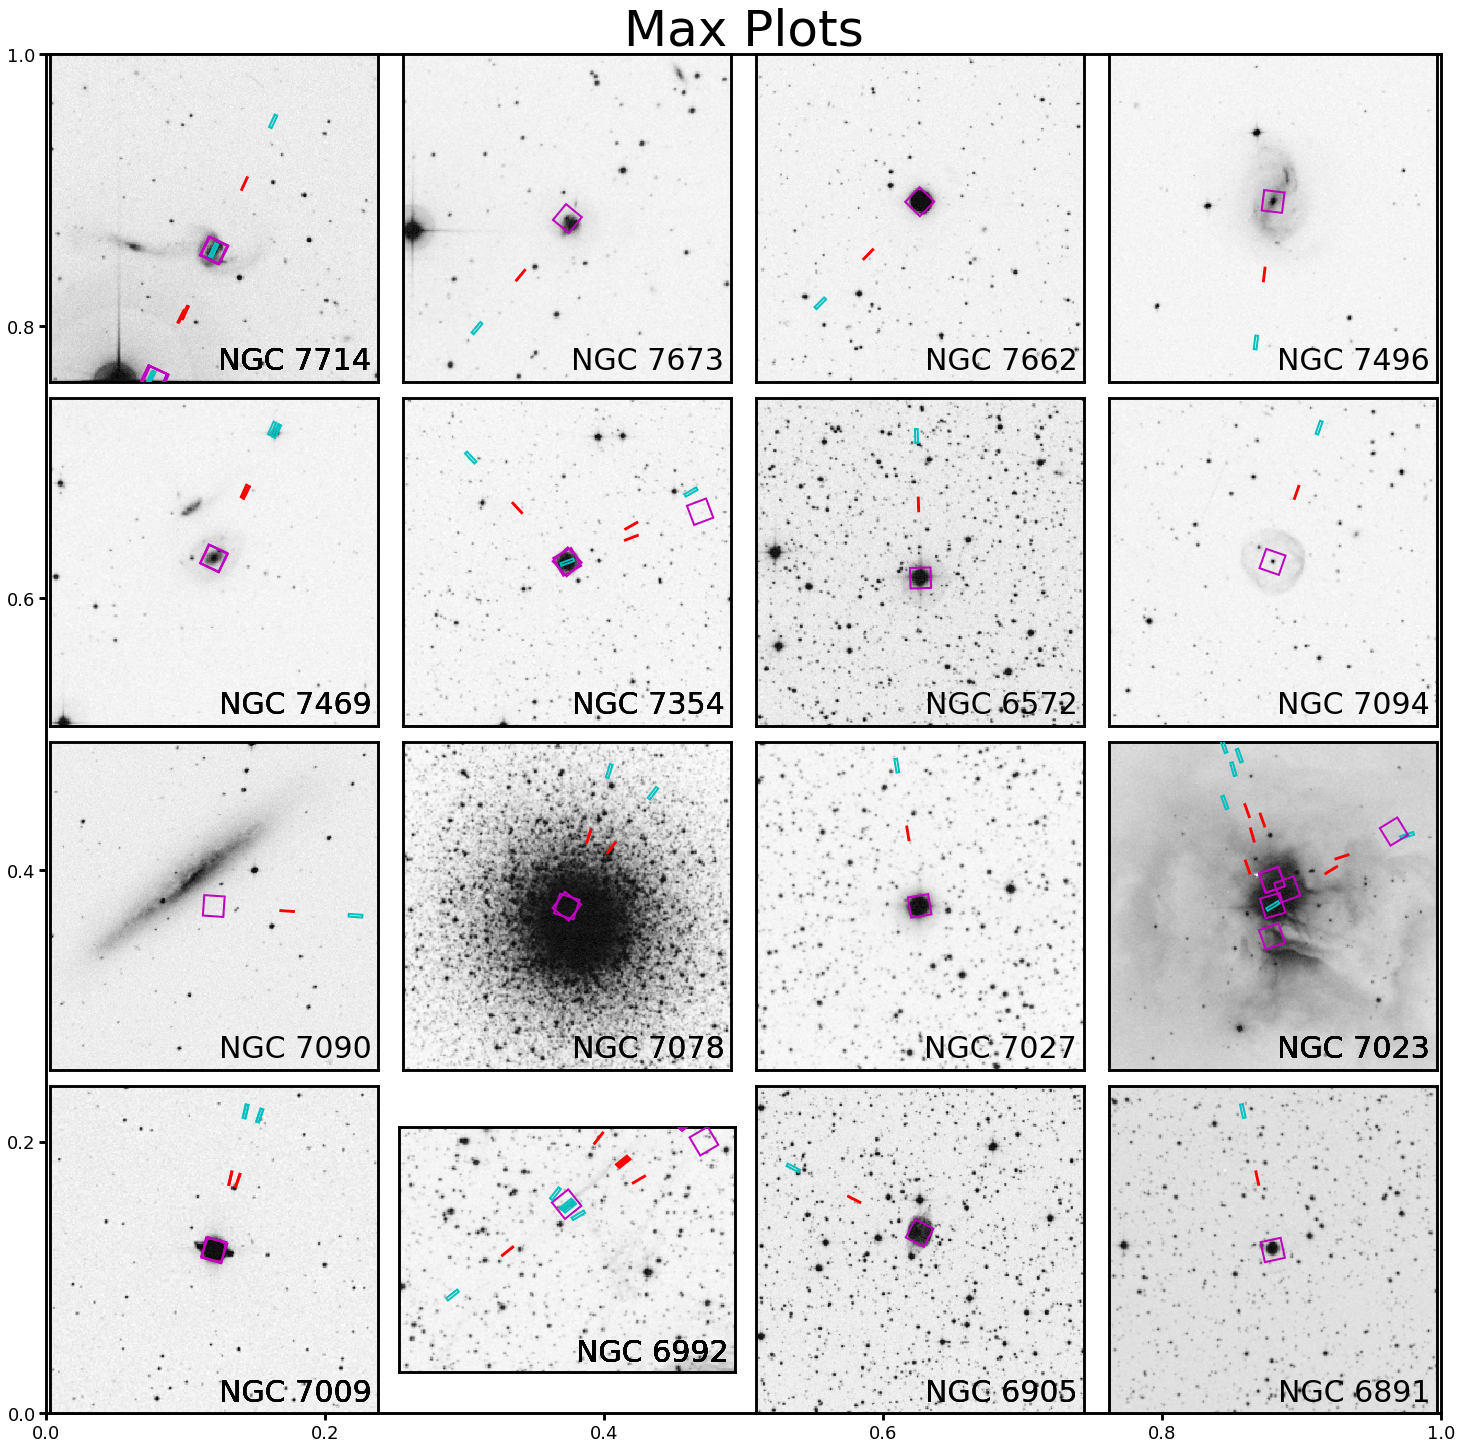

In [10]:
#Main Plotting Block

set_rcparams_prop(amp=1.15)

rr=1
aa=6
wrs=np.array([1.8, 0.2, 1.2, 0.05])
hrs=np.array([1])
fig = plt.figure(figsize=(20, 30))
fig = plt.figure(figsize=(25, 25))
plt.title("Max Plots",fontdict={'fontsize': 50})
ncol=4
nrow=4
gs1 = gridspec.GridSpec(nrow, ncol, figure=fig, 
#                         width_ratios=wrs, height_ratios=hrs,
                        hspace=0.05, wspace=0.05
                       )
pidxs=np.arange(ncol*nrow)
axs=[]
for i in range(len(pidxs)):
    ax=fig.add_subplot(gs1[i // ncol, i%ncol])
    axs.append(ax)


fidx=[0,0,0,0,0,
      0,0,0,0,0,
      0,0,0,0,0,
      0,0,0,0
     ]

# fidx=[1,0,0,0,0,
#       0,0,1,0,0,
#       0,0,0,0,0,
#       0,0,0,0
#      ]

# fidx=[1,0,0,0,0,
#       0,0,1,0,0,
#       1,0,0,1,0,
#       0,0,0,0
#      ]                 #Working for RED

# fidx=[1,1,1,1,1,
#       1,1,1,1,1,
#       1,1,1,1,1,
#       1,1,1,1
#      ]

# cut_widths=np.array([
#     350,300,400,400,
#     400,400,1400,1600,
#     600,1600,300,250,
#     250,250,500,400,
# ])/3600*2           # Working for RED

cut_widths=np.array([
    240,240,240,240,
    240,240,240,240,
    240,240,240,240,
    240,240,240,240,
])/3600*2 

print(cut_widths[1])


raoffs=np.array(
    [0,0,0,0,
     0.0,0,0.0,0,
     0,0,0,0,
     0,0,0,0,
    ]
)

decoffs=np.array(
    [0.1,0,-0.05,-0.05,
     -0.01,0,.05,0,
     0,0,0,0,
     0,0,-0.05,0,
    ]
)

minsep=0.5
file_sc=SkyCoord(fdf.ra, fdf.dec, frame='icrs', unit='deg')    

# for i  in [13]:
for i in range(len(objnames)):
    
# for i in range(8):

#     if i == 3 or i == 4 or i == 6 or i == 8 or i == 12 or i == 13:
#         continue
#     if i == 6:
#         continue
    ax=axs[i]
    objname=objnames[i]
    print(objname)
    sdf=df.loc[df['objname']==objname,:]
    sdf.index=np.arange(len(sdf))
    ra0, dec0=sdf.loc[0,'ra'], sdf.loc[0,'dec']
#     print(ra0, dec0)
    c = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    
    cond=np.array(file_sc.separation(c))<minsep
    match_df=fdf[cond]
    match_df.index=np.arange(np.sum(cond))
    
    if computer ==1:
        fits_file=match_df.loc[fidx[i],'file_path'][0:48] + match_df.loc[fidx[i],'file_path'][64:] #61forblue,60forred
        fits_file=match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][64:] #Skyview
    if computer == 2:
        fits_file=match_df.loc[fidx[i],'file_path'][0:62] + match_df.loc[fidx[i],'file_path'][78:] #Other comp
        fits_file=match_df.loc[fidx[i],'file_path'][0:58] + match_df.loc[fidx[i],'file_path'][78:] #Other comp Skyview

    print(fidx[i])
    print('number of matched DF', len(match_df))
    hdu=fits.open(os.path.normpath(fits_file))
    hdr=hdu[0].header
    oiwcs=astropy.wcs.WCS(header=hdr) 
    print(fits_file)
    
    cmap=cm.gray_r
    origin='lower'

    oim=hdu[0].data

    ra0, dec0=sdf.loc[0,'ra']+cut_widths[i]*raoffs[i], sdf.loc[0,'dec']+cut_widths[i]*decoffs[i]
#     print(ra0, dec0)
    cc = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    
    print(oiwcs,cc)
    print('npt',len(sdf))
    img_cutout_obj=Cutout2D(oim, cc, 
                       u.Quantity(cut_widths[i], unit='deg'),
                       wcs=oiwcs,
                    mode='trim',
#                     mode='partial',
                   )
    
    im=img_cutout_obj.data
    iwcs=img_cutout_obj.wcs

    
    img=ax.matshow(im, 
               cmap=cmap, 
               origin=origin, interpolation='none', 
#                zorder=1,
#               alpha=alpha, zorder=zorder, aspect=aspect, 
#                norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
                  )
#     print(objname)
    
    
    for j in range(len(sdf)):
        jra, jdec=sdf.loc[j,'ra'], sdf.loc[j,'dec']        
        c_obj=SkyCoord(jra, jdec, 
                                          unit='deg',
                                          frame='icrs')
        if sdf.loc[j,'aperture']=='MDRS':
            sep=u.Quantity(-90.18-118.07, unit='arcsec')
            c_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
            print('MDRS!!!')

        sep=u.Quantity(90.18+118.07, unit='arcsec')
        m_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
        sep=u.Quantity(-10.27+118.07, unit='arcsec')
        h_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
         
        objs=[c_obj, m_obj, h_obj]
        xws=[30,4,1.25]
        yws=[30,20,20]
        clrs=['m','c','r']
        
        for k in range(3):
            pcent_x, pcent_y=iwcs.world_to_pixel(objs[k])
            psm=iwcs.pixel_scale_matrix
            pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
    #         print('pscale',pscale)
            pxwidth=xws[k]/3600/pscale
            pywidth=yws[k]/3600/pscale
#             edgecolor='m'
            edgecolor=clrs[k]
    #         edgecolor='k'
            sqlw=2


            rot_ang=0
            rot_ang=sdf.loc[j,'pa']
            recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
            rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
                                             angle=rot_ang,
                                             zorder=20,
        #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
        #                                      angle=(-180),
        #                                   facecolor='w', fill=True)
                                    linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
            #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
            art=ax.add_artist(rec)
        ax.text(0.98,0.02,objname,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes,
                size=30
               )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
#         pcent_x, pcent_y=iwcs.world_to_pixel(m_obj)
#         psm=iwcs.pixel_scale_matrix
#         pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
# #         print('pscale',pscale)
#         pxwidth=4/3600/pscale
#         pywidth=20/3600/pscale
#         edgecolor='c'
# #         edgecolor='k'
#         sqlw=3

        
#         rot_ang=0
#         rot_ang=sdf.loc[j,'pa']
#         recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
#         rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
#                                          angle=rot_ang,
#                                          zorder=20,
#     #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
#     #                                      angle=(-180),
#     #                                   facecolor='w', fill=True)
#                                 linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
#         #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
#         art=ax.add_artist(rec)
    
csp=0.0
fig.subplots_adjust(wspace=csp, hspace=csp)

# aa=cc.separation(c)
# np.array(Angle(aa, unit=u.deg))<0.5
match_df

hdu.close()

fname='MaxNewTesttargets2.png'
#fig.savefig(fname,dpi=256, bbox_inches='tight')